In [15]:
!pip install wandb

In [16]:
!nvidia-smi

Mon Apr  4 16:59:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
from wandb.keras import WandbCallback

In [18]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Apr  4 16:59:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


### Dataset 


In [19]:

import os
from os.path import exists
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random 
import cv2
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
class Dataset:
    
    def downloadDataSet(self):
      cwd = os.getcwd()
     
      classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
      file_exists = exists('./nature_12K.zip')
      if(file_exists==False):
        print('downloading....')
        os.system('curl -SL https://storage.googleapis.com/wandb_datasets/nature_12K.zip > nature_12K.zip')
        print('download Complete')
      extract_exists = exists('./inaturalist_12K/')   
      if(extract_exists==False):  
        savePath=cwd
        savefile='./nature_12K.zip'
        print('Extracting..')
        with zipfile.ZipFile(savefile, 'r') as zip_ref:
            zip_ref.extractall(savePath)
        print('Complete')
       
        
    def showRandomImageOfEveryClass(self,imagesize=300):
       classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
       imagePath='./inaturalist_12K/train'
       listImages=[]
       columns = 5
       rows = 5
       imcount=1
       
       for i in classes:
           p=imagePath+'/'+i
           files=os.listdir( p)
           img=random.choice(files)
           imgplt=mpimg.imread( p+'/'+str(img))
           imgplt=cv2.resize(imgplt,(300,300)) 
           listImages.append(imgplt)
           #plt.imshow(imgplt)
           #fig.add_subplot(rows, columns, imcount)
           #imcount+=1
           #plt.axis('off')
           #plt.title(i) 
       
       _, axs = plt.subplots(1, 10, figsize=(15, 15))
       axs = axs.flatten()
       for img, ax,cls in zip(listImages, axs,classes):
         
           ax.imshow(img)
           ax.axis('off')
           ax.set_title(str(cls))
       plt.show()
    
    
    def import_dataset(self,seed,image_size=300,augment_data=False):
        #All variables 
        cwd=os.getcwd()
        batchsize=32
        image_size=image_size
        train_dir = './inaturalist_12K/train/'
        test_dir = './inaturalist_12K/val/'
        print('Training Dataset')

        #perform Augmentation if augment_data=True
        if augment_data:
            train_datagen = ImageDataGenerator(rescale=1./255,
                                          rotation_range=90,
                                          zoom_range=0.2,
                                          shear_range=0.2,
                                          validation_split=0.1,
                                          horizontal_flip=True)
            test_datagen = ImageDataGenerator(rescale=1./255)
        else:
            train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.1)
            test_datagen = ImageDataGenerator(rescale=1./255)

        train_ds = train_datagen.flow_from_directory(train_dir,subset="training", class_mode='sparse',color_mode='rgb',target_size=(image_size, image_size), batch_size=batchsize)
        val_ds = train_datagen.flow_from_directory(train_dir,subset="validation",class_mode='sparse', color_mode='rgb',target_size=(image_size, image_size), batch_size=batchsize)
        print('')
        print('Test Dataset')
        test_ds = test_datagen.flow_from_directory(test_dir, target_size=(image_size, image_size) ,class_mode='sparse',color_mode='rgb',batch_size=30)
    



    
        return train_ds,val_ds, test_ds
               

### Transfer Learning

In [20]:
"""
Following functions used to construct an CNN network

Parameters
---------
base_model: Name of the Base model
numberOfDenseLayer: Number of dense layer applied after base model
BatchNormalization: If true apply batch normalisation after each layer
number_of_neurons_dense_layer : Dense layer neuron 
number_of_classes: Total number of classes
dropout: dropout rate
batchNormalization: Whether batch normalization applied
no_of_last_trainable_layers: Last k layers remain trainable
"""
import numpy as np
import pandas as pd
import os
import keras
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from keras.layers import Conv2D , MaxPool2D,MaxPooling3D , Flatten , Dropout, Dense, Activation, BatchNormalization
class TransferLearn:

    def Train(self,base_model="inceptionv3",
            img_size=224,\
            activation_function="relu",\
            number_of_neurons_dense_layer=512,\
            number_of_classes=10,\
            dropout_rate=0,batchNormalization=False,\
            fraction_of_trainable_layers=0,numberOfDenseLayer=1,lr=1e-4,optimizer="adam",wandbLog=False):
       
        imgshape=(img_size,img_size,3)
        if(base_model.lower()=="inceptionv3"):
            base_model_def = tf.keras.applications.InceptionV3(input_shape=imgshape,
                                               include_top=False,
                                               weights='imagenet',classes=1000)
            
        if(base_model.lower()=='inceptionresnetv2'):
           
            base_model_def = tf.keras.applications.InceptionResNetV2(input_shape=imgshape,
                                               include_top=False,
                                               weights='imagenet',classes=1000)
        if(base_model.lower()=='resnet50'):
           
            base_model_def = tf.keras.applications.ResNet50(input_shape=imgshape,
                                               include_top=False,
                                               weights='imagenet',classes=1000)
        
        if(base_model.lower()=='xception'):

            base_model_def = tf.keras.applications.Xception(input_shape=imgshape,
                                               include_top=False,
                                               weights='imagenet',classes=1000)
        
        #--------------------------
        #Pretraining
        #-------------------------
        base_model_def.tranable=False

        model= Sequential()
        model.add(base_model_def) 
        model.add(Flatten()) 
        #Adding the Dense layers along with activation and batch normalization
        for i in range(numberOfDenseLayer):
            model.add(Dense(number_of_neurons_dense_layer,activation=(activation_function)))
            if (batchNormalization):
              model.add(tf.keras.layers.BatchNormalization())
        
        if(dropout_rate>0):
            model.add(Dropout(dropout_rate))
        model.add(Dense(10,activation=('softmax'))) 


        if(optimizer=="sgd"):
          model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr,momentum=0.9),\
              loss=[tf.keras.losses.SparseCategoricalCrossentropy()],\
              metrics=['accuracy']
              ) 
        else:
          model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),\
              loss=[tf.keras.losses.SparseCategoricalCrossentropy()],\
              metrics=['accuracy']
              ) 
        #early stopping as it may lead overfitting
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)
        #adding early condition
        if(wandbLog):
          hist=model.fit(train_ds, epochs=5,validation_data=val_ds,callbacks=[early_stop,WandbCallback()])
        else:
          hist=model.fit(train_ds, epochs=5,validation_data=val_ds,callbacks=[early_stop])
        #------------------------
        #fine tunning
        #-------------------------
        
        #no_of_last_trainable_layers if value zero we will train all
        total_layers=len(base_model_def.layers)
        no_of_last_trainable_layers=int(total_layers*fraction_of_trainable_layers)
        for i in range(total_layers-no_of_last_trainable_layers ,total_layers):
            base_model_def.layers[i].trainable=True
  
        #now train again with very low learning rate
        if(optimizer=="sgd"):
          model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr,momentum=0.9),\
              loss=[tf.keras.losses.SparseCategoricalCrossentropy()],\
              metrics=['accuracy']
              ) 
        else:
          model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),\
              loss=[tf.keras.losses.SparseCategoricalCrossentropy()],\
              metrics=['accuracy']
              ) 

     
          
        if(wandbLog):
          hist=model.fit(train_ds, epochs=5,validation_data=val_ds,callbacks=[early_stop,WandbCallback()])
        else:
          hist=model.fit(train_ds, epochs=5,validation_data=val_ds,callbacks=[early_stop])


        return model



In [21]:
ds=Dataset()

### Download data set

In [22]:
ds.downloadDataSet()

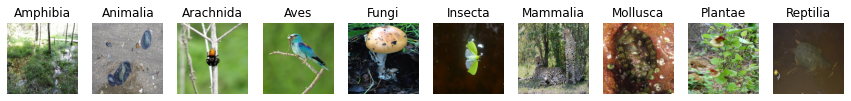

In [23]:
ds.showRandomImageOfEveryClass()

### Load data set

In [24]:
train_ds,val_ds,test_ds=ds.import_dataset(seed=42,image_size=300,augment_data=True)

Training Dataset
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.

Test Dataset
Found 2000 images belonging to 10 classes.


In [ ]:
#sample inputs
cnn=TransferLearn()

base_model="resnet50"
activation_function = 'relu'
number_of_neurons_in_the_dense_layer = 1024
dropout=0.5
number_of_classes=10
numberOfDenseLayer=1
img_size=300
batchNormalization=True
no_of_last_trainable_layers=2
no_of_last_trainable_layers=0
numberOfDenseLayer=2
epoch=5
wandbLog=False
model=cnn.Train(base_model,
                img_size,\
                activation_function,\
                number_of_neurons_in_the_dense_layer,\
                number_of_classes,\
                dropout,\
                BatchNormalization,\
                no_of_last_trainable_layers,numberOfDenseLayer,epoch,wandbLog) 


In [ ]:
model.evaluate(test_ds)

In [ ]:
# This is the main function to use to train/fine-tune the model using wandb runs
def train_wandb():
    run = wandb.init()
    image_shape=(300, 300)
    config=wandb.config
    # Set the run name
    name = str(config["base_model"]) + "_"
    name += " optimizer(" + str(config["optimizer"]) + ")_"
    name += " fraction_of_trainable_layers(" + str(config["fraction_of_trainable_layers"]) + ")_"
    name += "dropout_rate(" + str(config["dropout_rate"])+ ")_"
    name += "activation_function(" + str(config["activation_function"])+ ")_"
    name += "numberOfDenseLayer(" + str(config["numberOfDenseLayer"]) + ")_"
    name += "batchNormalization(" + str(config["batchNormalization"]) + ")"
    name += "lr(" + str(config["lr"]) + ")"
    wandb.run.name = name[:-1]
    #sample inputs
    cnn=TransferLearn()
    base_model=config["base_model"]
    activation_function = config["activation_function"]
    number_of_neurons_in_the_dense_layer = 512
    numberOfDenseLayer=config["numberOfDenseLayer"]
    dropout=0.3
    number_of_classes=10
    numberOfDenseLayer=1
    img_size=300
    lr=config["lr"]
    batchNormalization=config["batchNormalization"]
    optimizer=config["optimizer"]
    fraction_of_trainable_layers=config["fraction_of_trainable_layers"]
    model=cnn.Train(base_model,
                    img_size,\
                    activation_function,\
                    number_of_neurons_in_the_dense_layer,\
                    number_of_classes,\
                    dropout,\
                    BatchNormalization,\
                    fraction_of_trainable_layers,numberOfDenseLayer,lr,optimizer,wandbLog=True) 
 


In [25]:
import wandb
wandb.login()


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
  "name": "DLAssignmentQuesB",
  "method": "bayes",
  "metric": {
      "name": "validation_loss",
      "goal": "minimize",
  },
  
  "parameters": {
        "base_model": {
            "values": ["inceptionv3","resnet50", "inceptionresnetv2",  "xception"]
        },
        "lr":{
          "values":[1e-5,1e-4]  
        },
        "optimizer":{
          "values":['adam','sgd']  
        },
        "fraction_of_trainable_layers":{ "values": [1,.50,.75]},
        "dropout_rate":{ "values": [.3,0.4,0.5]},
        "batchNormalization":{ "values": [True,False]},
        "activation_function": {"values": ["relu","LeakyReLU"]},
        "numberOfDenseLayer":{"values":[1,2]}
        }
    }
sweep_id = wandb.sweep(sweep_config, entity="kankan-jana", project="CS6910_Assignment-2")
wandb.agent(sweep_id, train_wandb)

NameError: ignored

In [30]:
wandb.init(entity="kankan-jana",project="CS6910_Assignment-2")

## Steps to rerun disconnected Wandb

In [34]:
sweep_config = {
  "name": "DLAssignmentQuesB",
  "method": "bayes",
  "metric": {
      "name": "validation_loss",
      "goal": "minimize",
  },
  
  "parameters": {
        "base_model": {
            "values": ["inceptionv3","resnet50", "inceptionresnetv2",  "xception"]
        },
        "lr":{
          "values":[1e-5,1e-4]  
        },
        "optimizer":{
          "values":['adam','sgd']  
        },
        "fraction_of_trainable_layers":{ "values": [1,.50,.75]},
        "dropout_rate":{ "values": [.3,0.4,0.5]},
        "batchNormalization":{ "values": [True,False]},
        "activation_function": {"values": ["relu","LeakyReLU"]},
        "numberOfDenseLayer":{"values":[1,2]}
        }
    }

In [35]:
sweep_id = wandb.sweep(sweep_config, entity="kankan-jana", project="CS6910_Assignment-2")

Create sweep with ID: gr48zgpf
Sweep URL: https://wandb.ai/kankan-jana/CS6910_Assignment-2/sweeps/gr48zgpf


In [ ]:

wandb.agent("gb27evo2", train_wandb)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: 82cqjy31 with config:
wandb: 	activation_function: LeakyReLU
wandb: 	base_model: inceptionv3
wandb: 	batchNormalization: True
wandb: 	dropout_rate: 0.3
wandb: 	fraction_of_trainable_layers: 0.75
wandb: 	lr: 1e-05
wandb: 	numberOfDenseLayer: 1
wandb: 	optimizer: adam


87924736/87910968 [==============================] - 2s 0us/step
Epoch 1/5
282/282 [==============================] - 304s 1s/step - loss: 1.4843 - accuracy: 0.5917 - val_loss: 1.0722 - val_accuracy: 0.6917 - _timestamp: 1649092160.0000 - _runtime: 316.0000
Epoch 2/5
282/282 [==============================] - 279s 988ms/step - loss: 1.0361 - accuracy: 0.7030 - val_loss: 0.9536 - val_accuracy: 0.7307 - _timestamp: 1649092440.0000 - _runtime: 596.0000
Epoch 3/5
282/282 [==============================] - 278s 984ms/step - loss: 0.8804 - accuracy: 0.7390 - val_loss: 0.9312 - val_accuracy: 0.7327 - _timestamp: 1649092718.0000 - _runtime: 874.0000
Epoch 4/5
282/282 [==============================] - 282s 998ms/step - loss: 0.7829 - accuracy: 0.7659 - val_loss: 0.7995 - val_accuracy: 0.7688 - _timestamp: 1649092997.0000 - _runtime: 1153.0000
Epoch 5/5
282/282 [==============================] - 275s 974ms/step - loss: 0.6949 - accuracy: 0.7833 - val_loss: 0.8191 - val_accuracy: 0.7538 - _times

accuracy,▁▄▅▆▆▆▇▇██
epoch,▁▃▅▆█▁▃▅▆█
loss,█▅▄▃▃▃▂▂▁▁
val_accuracy,▁▃▃▅▅▆▇▇▇█
val_loss,█▆▆▃▄▃▂▁▂▁
accuracy,0.85733
best_epoch,4
best_val_loss,0.65551
epoch,4
loss,0.43342
val_accuracy,0.81281


wandb: Agent Starting Run: eclvh0uh with config:
wandb: 	activation_function: relu
wandb: 	base_model: inceptionv3
wandb: 	batchNormalization: True
wandb: 	dropout_rate: 0.5
wandb: 	fraction_of_trainable_layers: 0.5
wandb: 	lr: 1e-05
wandb: 	numberOfDenseLayer: 2
wandb: 	optimizer: adam


Epoch 1/5
282/282 [==============================] - 288s 995ms/step - loss: 1.4612 - accuracy: 0.5752 - val_loss: 1.0004 - val_accuracy: 0.6927 - _timestamp: 1649095014.0000 - _runtime: 295.0000
Epoch 2/5
282/282 [==============================] - 278s 984ms/step - loss: 1.0259 - accuracy: 0.6909 - val_loss: 0.8808 - val_accuracy: 0.7187 - _timestamp: 1649095292.0000 - _runtime: 573.0000
Epoch 3/5
282/282 [==============================] - 278s 984ms/step - loss: 0.8805 - accuracy: 0.7308 - val_loss: 0.8168 - val_accuracy: 0.7588 - _timestamp: 1649095570.0000 - _runtime: 851.0000
Epoch 4/5
282/282 [==============================] - 280s 992ms/step - loss: 0.7565 - accuracy: 0.7653 - val_loss: 0.7823 - val_accuracy: 0.7738 - _timestamp: 1649095849.0000 - _runtime: 1130.0000
Epoch 5/5
282/282 [==============================] - 279s 988ms/step - loss: 0.6943 - accuracy: 0.7839 - val_loss: 0.7575 - val_accuracy: 0.7718 - _timestamp: 1649096130.0000 - _runtime: 1411.0000
Epoch 1/5
282/282 

accuracy,▁▄▅▆▆▆▇▇██
epoch,▁▃▅▆█▁▃▅▆█
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▆▇▆▇▇▆██
val_loss,█▅▄▃▃▃▂▂▂▁
accuracy,0.85844
best_epoch,4
best_val_loss,0.68322
epoch,4
loss,0.44374
val_accuracy,0.79279


wandb: Agent Starting Run: cpkrf7l6 with config:
wandb: 	activation_function: LeakyReLU
wandb: 	base_model: inceptionresnetv2
wandb: 	batchNormalization: True
wandb: 	dropout_rate: 0.3
wandb: 	fraction_of_trainable_layers: 0.75
wandb: 	lr: 1e-05
wandb: 	numberOfDenseLayer: 2
wandb: 	optimizer: sgd


219070464/219055592 [==============================] - 4s 0us/step
Epoch 1/5
282/282 [==============================] - 367s 1s/step - loss: 1.9317 - accuracy: 0.4404 - val_loss: 1.2094 - val_accuracy: 0.6296 - _timestamp: 1649097953.0000 - _runtime: 382.0000
Epoch 2/5
282/282 [==============================] - 340s 1s/step - loss: 1.3345 - accuracy: 0.6179 - val_loss: 1.0641 - val_accuracy: 0.6807 - _timestamp: 1649098295.0000 - _runtime: 724.0000
Epoch 3/5
282/282 [==============================] - 340s 1s/step - loss: 1.2191 - accuracy: 0.6460 - val_loss: 1.0080 - val_accuracy: 0.6907 - _timestamp: 1649098634.0000 - _runtime: 1063.0000
Epoch 4/5
282/282 [==============================] - 339s 1s/step - loss: 1.1389 - accuracy: 0.6770 - val_loss: 1.0078 - val_accuracy: 0.6947 - _timestamp: 1649098974.0000 - _runtime: 1403.0000
Epoch 5/5
282/282 [==============================] - 340s 1s/step - loss: 1.0986 - accuracy: 0.6863 - val_loss: 0.9397 - val_accuracy: 0.7247 - _timestamp: 164

accuracy,▁▅▆▇▇▇▇███
epoch,▁▃▅▆█▁▃▅▆█
loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▅▅▇▇█▇▇█
val_loss,█▅▄▄▂▂▂▁▂▁
accuracy,0.72489
best_epoch,2
best_val_loss,0.87414
epoch,4
loss,0.9426
val_accuracy,0.74775


wandb: Agent Starting Run: khkf6rnz with config:
wandb: 	activation_function: LeakyReLU
wandb: 	base_model: resnet50
wandb: 	batchNormalization: True
wandb: 	dropout_rate: 0.5
wandb: 	fraction_of_trainable_layers: 1
wandb: 	lr: 0.0001
wandb: 	numberOfDenseLayer: 1
wandb: 	optimizer: adam


94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/5
282/282 [==============================] - 298s 1s/step - loss: 1.6421 - accuracy: 0.5886 - val_loss: 5.8748 - val_accuracy: 0.1011 - _timestamp: 1649101418.0000 - _runtime: 299.0000
Epoch 2/5
282/282 [==============================] - 278s 984ms/step - loss: 0.8887 - accuracy: 0.7178 - val_loss: 3.2476 - val_accuracy: 0.1932 - _timestamp: 1649101702.0000 - _runtime: 583.0000
Epoch 3/5
282/282 [==============================] - 280s 991ms/step - loss: 0.7431 - accuracy: 0.7594 - val_loss: 1.5555 - val_accuracy: 0.5135 - _timestamp: 1649101981.0000 - _runtime: 862.0000
Epoch 4/5
282/282 [==============================] - 280s 991ms/step - loss: 0.6348 - accuracy: 0.7967 - val_loss: 1.0102 - val_accuracy: 0.7037 - _timestamp: 1649102259.0000 - _runtime: 1140.0000
Epoch 5/5
282/282 [==============================] - 278s 985ms/step - loss: 0.5733 - accuracy: 0.8133 - val_loss: 0.8477 - val_accuracy: 0.7187 - _times

accuracy,▁▄▅▆▇▇▇▇█
epoch,▁▃▅▆█▁▃▅▆
loss,█▄▃▂▂▂▂▁▁
val_accuracy,▁▂▆██████
val_loss,█▄▂▁▁▁▁▁▁
accuracy,0.85656
best_epoch,4
best_val_loss,0.84774
epoch,3
loss,0.44221
val_accuracy,0.7047


wandb: Agent Starting Run: fo9fwec4 with config:
wandb: 	activation_function: relu
wandb: 	base_model: resnet50
wandb: 	batchNormalization: False
wandb: 	dropout_rate: 0.3
wandb: 	fraction_of_trainable_layers: 1
wandb: 	lr: 0.0001
wandb: 	numberOfDenseLayer: 1
wandb: 	optimizer: adam


Epoch 1/5
282/282 [==============================] - 284s 989ms/step - loss: 1.3765 - accuracy: 0.5882 - val_loss: 10.8898 - val_accuracy: 0.1011 - _timestamp: 1649103981.0000 - _runtime: 285.0000
Epoch 2/5
282/282 [==============================] - 275s 973ms/step - loss: 0.8642 - accuracy: 0.7190 - val_loss: 5.3957 - val_accuracy: 0.1341 - _timestamp: 1649104260.0000 - _runtime: 564.0000
Epoch 3/5
282/282 [==============================] - 276s 976ms/step - loss: 0.7214 - accuracy: 0.7643 - val_loss: 1.9806 - val_accuracy: 0.4284 - _timestamp: 1649104536.0000 - _runtime: 840.0000
Epoch 4/5
282/282 [==============================] - 277s 979ms/step - loss: 0.5984 - accuracy: 0.8067 - val_loss: 1.0175 - val_accuracy: 0.6897 - _timestamp: 1649104809.0000 - _runtime: 1113.0000
Epoch 5/5
282/282 [==============================] - 276s 977ms/step - loss: 0.5256 - accuracy: 0.8224 - val_loss: 0.9528 - val_accuracy: 0.7097 - _timestamp: 1649105090.0000 - _runtime: 1394.0000
Epoch 1/5
282/282

accuracy,▁▅▆▇▇▇▇█
epoch,▁▃▅▆█▁▃▅
loss,█▄▃▂▁▂▁▁
val_accuracy,▁▁▅█████
val_loss,█▄▂▁▁▁▁▁
accuracy,0.84589
best_epoch,4
best_val_loss,0.95276
epoch,2
loss,0.46771
val_accuracy,0.71371


wandb: Agent Starting Run: ill71fpt with config:
wandb: 	activation_function: relu
wandb: 	base_model: resnet50
wandb: 	batchNormalization: False
wandb: 	dropout_rate: 0.4
wandb: 	fraction_of_trainable_layers: 0.5
wandb: 	lr: 0.0001
wandb: 	numberOfDenseLayer: 2
wandb: 	optimizer: sgd


Epoch 1/5
282/282 [==============================] - 277s 962ms/step - loss: 1.5574 - accuracy: 0.5344 - val_loss: 3.5428 - val_accuracy: 0.1011 - _timestamp: 1649106255.0000 - _runtime: 285.0000
Epoch 2/5
282/282 [==============================] - 267s 946ms/step - loss: 1.0261 - accuracy: 0.6800 - val_loss: 3.6201 - val_accuracy: 0.1912 - _timestamp: 1649106525.0000 - _runtime: 555.0000
Epoch 3/5
282/282 [==============================] - 272s 964ms/step - loss: 0.8721 - accuracy: 0.7247 - val_loss: 1.6121 - val_accuracy: 0.5105 - _timestamp: 1649106793.0000 - _runtime: 823.0000
Epoch 4/5
282/282 [==============================] - 278s 983ms/step - loss: 0.7590 - accuracy: 0.7557 - val_loss: 0.9427 - val_accuracy: 0.7057 - _timestamp: 1649107069.0000 - _runtime: 1099.0000
Epoch 5/5
282/282 [==============================] - 275s 971ms/step - loss: 0.6693 - accuracy: 0.7808 - val_loss: 0.8417 - val_accuracy: 0.7518 - _timestamp: 1649107347.0000 - _runtime: 1377.0000
Epoch 1/5
282/282 

accuracy,▁▄▅▆▇▇███
epoch,▁▃▅▆█▁▃▅▆
loss,█▅▃▃▂▂▁▁▁
val_accuracy,▁▂▅▇█████
val_loss,██▃▁▁▁▁▁▁
accuracy,0.83356
best_epoch,1
best_val_loss,0.77236
epoch,3
loss,0.49147
val_accuracy,0.75375


wandb: Agent Starting Run: 38fgusgf with config:
wandb: 	activation_function: LeakyReLU
wandb: 	base_model: inceptionresnetv2
wandb: 	batchNormalization: True
wandb: 	dropout_rate: 0.3
wandb: 	fraction_of_trainable_layers: 1
wandb: 	lr: 1e-05
wandb: 	numberOfDenseLayer: 1
wandb: 	optimizer: sgd


Epoch 1/5
282/282 [==============================] - 358s 1s/step - loss: 1.9040 - accuracy: 0.4391 - val_loss: 1.1393 - val_accuracy: 0.6637 - _timestamp: 1649108908.0000 - _runtime: 370.0000
Epoch 2/5
282/282 [==============================] - 339s 1s/step - loss: 1.3272 - accuracy: 0.6173 - val_loss: 1.1290 - val_accuracy: 0.6687 - _timestamp: 1649109247.0000 - _runtime: 709.0000
Epoch 3/5
282/282 [==============================] - 340s 1s/step - loss: 1.2053 - accuracy: 0.6492 - val_loss: 0.9818 - val_accuracy: 0.7117 - _timestamp: 1649109585.0000 - _runtime: 1047.0000
Epoch 4/5
282/282 [==============================] - 339s 1s/step - loss: 1.1333 - accuracy: 0.6686 - val_loss: 0.9524 - val_accuracy: 0.7147 - _timestamp: 1649109926.0000 - _runtime: 1388.0000
Epoch 5/5
282/282 [==============================] - 336s 1s/step - loss: 1.0758 - accuracy: 0.6898 - val_loss: 0.9730 - val_accuracy: 0.6997 - _timestamp: 1649110264.0000 - _runtime: 1726.0000
Epoch 1/5
282/282 [=============

accuracy,▁▅▆▇▇▇████
epoch,▁▃▅▆█▁▃▅▆█
loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▁▅▅▄▅▆▇▇█
val_loss,██▄▄▄▃▂▁▂▁
accuracy,0.72189
best_epoch,2
best_val_loss,0.83607
epoch,4
loss,0.9425
val_accuracy,0.75275


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u38mld14 with config:
wandb: 	activation_function: LeakyReLU
wandb: 	base_model: resnet50
wandb: 	batchNormalization: False
wandb: 	dropout_rate: 0.3
wandb: 	fraction_of_trainable_layers: 1
wandb: 	lr: 0.0001
wandb: 	numberOfDenseLayer: 2
wandb: 	optimizer: adam


Epoch 1/5
282/282 [==============================] - 283s 984ms/step - loss: 1.5580 - accuracy: 0.5966 - val_loss: 4.6253 - val_accuracy: 0.1001 - _timestamp: 1649112318.0000 - _runtime: 287.0000
Epoch 2/5
282/282 [==============================] - 274s 968ms/step - loss: 0.9007 - accuracy: 0.7163 - val_loss: 3.2523 - val_accuracy: 0.1461 - _timestamp: 1649112593.0000 - _runtime: 562.0000
Epoch 3/5
282/282 [==============================] - 273s 966ms/step - loss: 0.7344 - accuracy: 0.7667 - val_loss: 1.5045 - val_accuracy: 0.5335 - _timestamp: 1649112865.0000 - _runtime: 834.0000
Epoch 4/5
282/282 [==============================] - 272s 962ms/step - loss: 0.6487 - accuracy: 0.7853 - val_loss: 0.8596 - val_accuracy: 0.7307 - _timestamp: 1649113137.0000 - _runtime: 1106.0000
Epoch 5/5
282/282 [==============================] - 267s 946ms/step - loss: 0.5764 - accuracy: 0.8134 - val_loss: 1.0072 - val_accuracy: 0.7117 - _timestamp: 1649113410.0000 - _runtime: 1379.0000
Epoch 1/5
282/282 

accuracy,▁▄▆▆▇▇▇██
epoch,▁▃▅▆█▁▃▅▆
loss,█▄▃▂▂▂▂▁▁
val_accuracy,▁▂▆██▇███
val_loss,█▅▂▁▁▁▁▁▁
accuracy,0.85311
best_epoch,3
best_val_loss,0.85963
epoch,3
loss,0.45358
val_accuracy,0.71071


wandb: Agent Starting Run: or7levbz with config:
wandb: 	activation_function: relu
wandb: 	base_model: resnet50
wandb: 	batchNormalization: True
wandb: 	dropout_rate: 0.4
wandb: 	fraction_of_trainable_layers: 1
wandb: 	lr: 1e-05
wandb: 	numberOfDenseLayer: 1
wandb: 	optimizer: sgd


Epoch 1/5
282/282 [==============================] - 280s 973ms/step - loss: 2.3437 - accuracy: 0.3010 - val_loss: 5.7927 - val_accuracy: 0.1001 - _timestamp: 1649114837.0000 - _runtime: 286.0000
Epoch 2/5
282/282 [==============================] - 272s 963ms/step - loss: 1.6394 - accuracy: 0.4919 - val_loss: 3.4011 - val_accuracy: 0.1772 - _timestamp: 1649115111.0000 - _runtime: 560.0000
Epoch 3/5
282/282 [==============================] - 273s 967ms/step - loss: 1.4078 - accuracy: 0.5619 - val_loss: 1.8541 - val_accuracy: 0.4274 - _timestamp: 1649115383.0000 - _runtime: 832.0000
Epoch 4/5
282/282 [==============================] - 271s 959ms/step - loss: 1.2939 - accuracy: 0.5924 - val_loss: 1.2023 - val_accuracy: 0.6126 - _timestamp: 1649115656.0000 - _runtime: 1105.0000
Epoch 5/5
282/282 [==============================] - 273s 968ms/step - loss: 1.2050 - accuracy: 0.6289 - val_loss: 1.0673 - val_accuracy: 0.6707 - _timestamp: 1649115928.0000 - _runtime: 1377.0000
Epoch 1/5
282/282 

accuracy,▁▄▆▆▇▇▇███
epoch,▁▃▅▆█▁▃▅▆█
loss,█▄▃▃▂▂▁▁▁▁
val_accuracy,▁▂▅▇██████
val_loss,█▅▂▁▁▁▁▁▁▁
accuracy,0.69211
best_epoch,4
best_val_loss,0.92776
epoch,4
loss,0.97542
val_accuracy,0.7007


wandb: Agent Starting Run: dlskt8gm with config:
wandb: 	activation_function: LeakyReLU
wandb: 	base_model: xception
wandb: 	batchNormalization: False
wandb: 	dropout_rate: 0.3
wandb: 	fraction_of_trainable_layers: 0.75
wandb: 	lr: 0.0001
wandb: 	numberOfDenseLayer: 1
wandb: 	optimizer: sgd


83697664/83683744 [==============================] - 2s 0us/step
Epoch 1/5
282/282 [==============================] - 367s 1s/step - loss: 1.2994 - accuracy: 0.6474 - val_loss: 0.9938 - val_accuracy: 0.7227 - _timestamp: 1649117762.0000 - _runtime: 375.0000
Epoch 2/5
282/282 [==============================] - 356s 1s/step - loss: 0.9546 - accuracy: 0.7232 - val_loss: 0.8569 - val_accuracy: 0.7588 - _timestamp: 1649118119.0000 - _runtime: 732.0000
Epoch 3/5
282/282 [==============================] - 354s 1s/step - loss: 0.8220 - accuracy: 0.7518 - val_loss: 0.8682 - val_accuracy: 0.7407 - _timestamp: 1649118477.0000 - _runtime: 1090.0000
Epoch 4/5
282/282 [==============================] - 357s 1s/step - loss: 0.7427 - accuracy: 0.7723 - val_loss: 0.8169 - val_accuracy: 0.7618 - _timestamp: 1649118830.0000 - _runtime: 1443.0000
Epoch 5/5
282/282 [==============================] - 357s 1s/step - loss: 0.6886 - accuracy: 0.7846 - val_loss: 0.7618 - val_accuracy: 0.7658 - _timestamp: 16491

accuracy,▁▄▅▆▆▇▇██
epoch,▁▃▅▆█▁▃▅▆
loss,█▅▄▃▂▂▂▁▁
val_accuracy,▁▅▃▅▅▆▇▇█
val_loss,█▅▅▄▂▂▁▂▁
accuracy,0.82422
best_epoch,1
best_val_loss,0.71082
epoch,3
loss,0.53756
val_accuracy,0.79279


wandb: Agent Starting Run: f8rmlcem with config:
wandb: 	activation_function: relu
wandb: 	base_model: resnet50
wandb: 	batchNormalization: True
wandb: 	dropout_rate: 0.4
wandb: 	fraction_of_trainable_layers: 0.5
wandb: 	lr: 1e-05
wandb: 	numberOfDenseLayer: 1
wandb: 	optimizer: sgd


Epoch 1/5
282/282 [==============================] - 282s 979ms/step - loss: 2.3584 - accuracy: 0.3049 - val_loss: 5.9129 - val_accuracy: 0.0941 - _timestamp: 1649120921.0000 - _runtime: 286.0000
Epoch 2/5
282/282 [==============================] - 273s 966ms/step - loss: 1.6219 - accuracy: 0.4962 - val_loss: 4.0550 - val_accuracy: 0.1211 - _timestamp: 1649121197.0000 - _runtime: 562.0000
Epoch 3/5
282/282 [==============================] - 271s 959ms/step - loss: 1.3938 - accuracy: 0.5660 - val_loss: 2.0506 - val_accuracy: 0.4214 - _timestamp: 1649121468.0000 - _runtime: 833.0000
Epoch 4/5
282/282 [==============================] - 274s 968ms/step - loss: 1.2731 - accuracy: 0.5962 - val_loss: 1.1445 - val_accuracy: 0.6206 - _timestamp: 1649121740.0000 - _runtime: 1105.0000
Epoch 5/5
282/282 [==============================] - 273s 967ms/step - loss: 1.1982 - accuracy: 0.6258 - val_loss: 1.0325 - val_accuracy: 0.6577 - _timestamp: 1649122015.0000 - _runtime: 1380.0000
Epoch 1/5
282/282 

accuracy,▁▄▆▆▇▇▇███
epoch,▁▃▅▆█▁▃▅▆█
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▁▅▇▇█████
val_loss,█▅▃▁▁▁▁▁▁▁
accuracy,0.697
best_epoch,3
best_val_loss,0.91554
epoch,4
loss,0.9756
val_accuracy,0.68669


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6hcdtayl with config:
wandb: 	activation_function: relu
wandb: 	base_model: resnet50
wandb: 	batchNormalization: False
wandb: 	dropout_rate: 0.4
wandb: 	fraction_of_trainable_layers: 1
wandb: 	lr: 0.0001
wandb: 	numberOfDenseLayer: 2
wandb: 	optimizer: adam


Epoch 1/5
246/282 [=========================>....] - ETA: 30s - loss: 1.4009 - accuracy: 0.5837